In [7]:
import sys
sys.path.append('..')
from dataset import ModisDataset, Sentinel5Dataset
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from model import Model, snapshot, restore
import ignite.metrics
import pandas as pd
from train import train_epoch, test_epoch, test_model, fine_tune
from visualizations import make_and_plot_predictions, predict_future
from dataset import transform_data
from copy import deepcopy

from datetime import datetime
def get_idx(date_array, date_str):
    return np.where(np.isin(date_array.astype(str),date_str))[0][0]

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

num_layers = 3
hidden_size = 32
region = "germany"
epochs = 2
include_time = False

model_dir="/data2/igarss2020/models/"
log_dir = "/data2/igarss2020/models/"
name_pattern = "LSTM_{region}_l={num_layers}_h={hidden_size}_e={epoch}"
log_pattern = "LSTM_{region}_l={num_layers}_h={hidden_size}"

def criterion(y_pred, y_data, log_variances):
    norm = (y_pred-y_data)**2
    loss = (torch.exp(-log_variances) * norm).mean()
    regularization = log_variances.mean()
    return 0.5 * (loss + regularization)

model = Model(input_size=1 if not include_time else 2,
              hidden_size=hidden_size,
              num_layers=num_layers,
              output_size=1,
              device=device)

#model.load_state_dict(torch.load("/tmp/model_epoch_0.pth")["model"])
model.train()

enddate = '2010-01-01'

dataset = ModisDataset(region=region,
                       fold="train",
                       znormalize=True,
                       augment=False,
                       overwrite=False,
                       include_time=include_time,
                       filter_date=(None,enddate),
                       smooth=3,
                       smooth_method="median")

testdataset = ModisDataset(region=region,
                       fold="test",
                       znormalize=True,
                       augment=False,
                       overwrite=False,
                       include_time=include_time,
                       filter_date=(None,None),
                       smooth=3,
                       smooth_method="median")

validdataset = ModisDataset(region=region,
                            fold="validate",
                            znormalize=True,
                            augment=False,
                            include_time=include_time,
                           smooth=3,
                           smooth_method="median")

#dataset = Sentinel5Dataset(fold="train", seq_length=300)
#validdataset = Sentinel5Dataset(fold="validate", seq_length=300)

dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=512,
                                         shuffle=True,
                                         #sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(10000))
                                         )
validdataloader = torch.utils.data.DataLoader(validdataset,
                                         batch_size=512,
                                         shuffle=False,
                                         #sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(10000))
                                         )

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)


local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
train_uptodate=2010-01-01 provided. removing all observations before 2010-01-01
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz



epoch 0: train loss -0.21, test loss -0.41, mae=0.31, mse=0.18, rmse=0.42
saving model snapshot to /data2/igarss2020/models/LSTM_germany_l=3_h=32_e=0.pth



epoch 1: train loss -0.42, test loss -0.45, mae=0.30, mse=0.17, rmse=0.41
saving model snapshot to /data2/igarss2020/models/LSTM_germany_l=3_h=32_e=1.pth



epoch 2: train loss -0.45, test loss -0.47, mae=0.30, mse=0.17, rmse=0.41
saving model snapshot to /data2/igarss2020/models/LSTM_germany_l=3_h=32_e=2.pth



epoch 3: train loss -0.46, test loss -0.48, mae=0.30, mse=0.16, rmse=0.41
saving model snapshot to /data2/igarss2020/models/LSTM_germany_l=3_h=32_e=3.pth



epoch 4: train loss -0.48, test loss -0.49, mae=0.29, mse=0.16, rmse=0.40
saving model snapshot to /data2/igarss2020/models/LSTM_germany_l=3_h=32_e=4.pth



epoch 5: train loss -0.49, test loss -0.50, mae=0.29, mse=0.16, rmse=0.40
saving model snapshot to /data2/igarss2020/models/LSTM_germany_l=3_h=32_e=5.pth



epoch 6: train loss -0.50, test loss -0.51, mae=0.29, mse=0.16, rmse=0.40
saving model snapshot to /data2/igarss2020/models/LSTM_germany_l=3_h=32_e=6.pth



epoch 7: train loss -0.51, test loss -0.52, mae=0.29, mse=0.16, rmse=0.40
saving model snapshot to /data2/igarss2020/models/LSTM_germany_l=3_h=32_e=7.pth



epoch 8: train loss -0.52, test loss -0.53, mae=0.29, mse=0.15, rmse=0.39
saving model snapshot to /data2/igarss2020/models/LSTM_germany_l=3_h=32_e=8.pth



epoch 9: train loss -0.52, test loss -0.53, mae=0.29, mse=0.15, rmse=0.39
saving model snapshot to /data2/igarss2020/models/LSTM_germany_l=3_h=32_e=9.pth


Text(0, 0.5, 'loss')

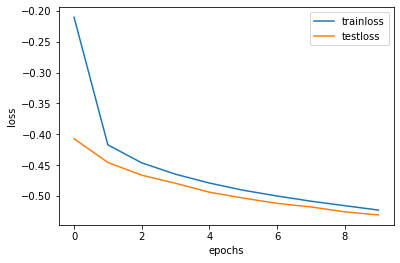

In [8]:
stats=list()
for epoch in range(epochs):
    trainloss = train_epoch(model,dataloader,optimizer, criterion, device)
    testmetrics, testloss = test_epoch(model,validdataloader,device, criterion, n_predictions=1)
    metric_msg = ", ".join([f"{name}={metric.compute():.2f}" for name, metric in testmetrics.items()])
    msg = f"epoch {epoch}: train loss {trainloss:.2f}, test loss {testloss:.2f}, {metric_msg}"
    print(msg)

    #test_model(model, validdataset, device)

    model_name = name_pattern.format(region=region, num_layers=num_layers, hidden_size=hidden_size, epoch=epoch)
    pth = os.path.join(model_dir, model_name+".pth")
    print(f"saving model snapshot to {pth}")
    snapshot(model, optimizer, pth)
    stat = dict()
    stat["epoch"] = epoch
    for name, metric in testmetrics.items():
        stat[name]=metric.compute()

    stat["trainloss"] = trainloss.cpu().detach().numpy()
    stat["testloss"] = testloss.cpu().detach().numpy()
    stats.append(stat)

df = pd.DataFrame(stats)

fig,ax = plt.subplots()
ax.plot(df.epoch, df.trainloss, label="trainloss")
ax.plot(df.epoch, df.testloss, label="testloss")
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')

(<Figure size 1008x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff0c116ca20>,
       dtype=object))

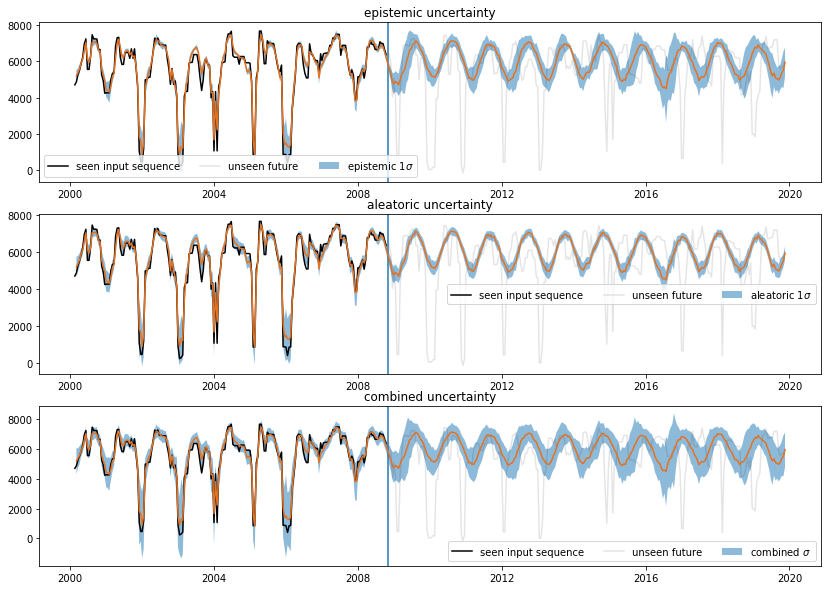

In [9]:
# Plotting
idx = 199
n_predictions = N_predictions = 10
N_seen_points=200

x = testdataset.data[idx].astype(float)
date = testdataset.date[idx].astype(np.datetime64)
store=None
make_and_plot_predictions(model, x, date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                              device=device,meanstd=(dataset.mean,dataset.std), store=store)

In [10]:


def forward_with_injection(model, x,future_before_injecting_data, future_after_injecting_data, 
                           num_inject, N_samples_seen):
    input = torch.Tensor(x)[None, :N_samples_seen].to(device)

    h_t = torch.zeros(model.num_layers, input.size(0), model.hidden_size, dtype=torch.float32).to(model.device)
    c_t = torch.zeros(model.num_layers, input.size(0), model.hidden_size, dtype=torch.float32).to(model.device)

    # encode a sequence of inputs
    outputs, log_variances, (h_t, c_t) = model.encode(input,h_t, c_t)

    # predict future_before_injecting_data time steps
    future_outputs, future_logvariances, (h_t, c_t) = model.decode(outputs[:,-1], h_t, c_t, future_before_injecting_data, return_states=True)
    outputs = torch.cat([outputs,future_outputs],1)
    log_variances = torch.cat([log_variances,future_logvariances],1)

    # encode single data point again
    inject_start = outputs.shape[1]
    inject_end = outputs.shape[1]+num_inject
    
    injected_input = torch.Tensor(x)[None, inject_start:inject_end].to(device)
    future_outputs, future_logvariances, (h_t, c_t) = model.encode(injected_input,h_t, c_t)
    outputs = torch.cat([outputs,future_outputs],1)
    log_variances = torch.cat([log_variances,future_logvariances],1)

    # predict another future_after_injecting_data time steps
    future_outputs, future_logvariances, (h_t, c_t) = model.decode(outputs[:,-1], h_t, c_t, future_after_injecting_data, return_states=True)
    outputs = torch.cat([outputs,future_outputs],1)
    log_variances = torch.cat([log_variances,future_logvariances],1)
    return outputs, log_variances

def predict_with_injection(model, x, n_predictions, future_before_injecting_data, 
                           future_after_injecting_data, num_inject, N_samples_seen):
    from model import variance

    outputs = list()
    variances = list()

    for n in range(n_predictions):
        with torch.no_grad():
            output, log_variance = forward_with_injection(model, x, future_before_injecting_data, 
                                                          future_after_injecting_data, num_inject, N_samples_seen)
        outputs.append(output)
        variances.append(log_variance.exp())

    var_hat = torch.stack(variances)
    y_hat = torch.stack(outputs)

    epi_var, ale_var = variance(y_hat, var_hat)
    mean = y_hat.mean(0)
    return mean, epi_var, ale_var


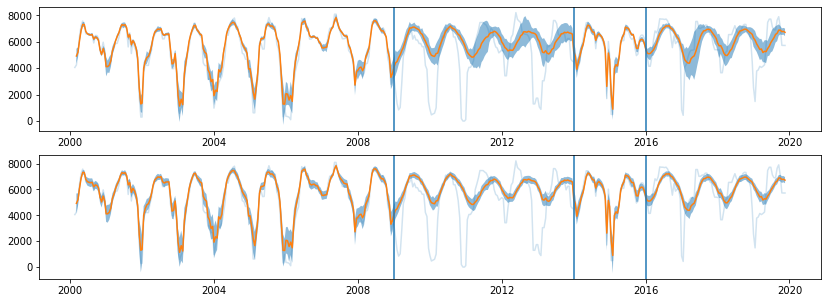

In [17]:
n_sigma=1
idx=6

x = testdataset.data[idx].astype(float)
date = testdataset.date[idx].astype(np.datetime64)

encode_end = get_idx(date,'2009-01-01')
inject_start = get_idx(date,'2014-01-01')
inject_end = get_idx(date,'2016-01-01')

future_before_injecting_data = inject_start - encode_end
#future_after_injecting_data = 100
N_samples_seen=encode_end
num_inject=inject_end-inject_start

future_after_injecting_data = x.shape[0] - (N_samples_seen + future_before_injecting_data + num_inject)

injected_at = N_samples_seen + future_before_injecting_data

x_ = torch.Tensor(x)[None, :].to(device)

mean, epi_var, ale_var = predict_with_injection(model, 
                                                x, 
                                                n_predictions, 
                                                future_before_injecting_data, 
                                                future_after_injecting_data, 
                                                num_inject,
                                                N_samples_seen)

var = epi_var + ale_var

mean = mean.cpu().squeeze()
var = var.cpu().squeeze()
epi_var = epi_var.cpu().squeeze()
ale_var = ale_var.cpu().squeeze()

epi_std = torch.sqrt(epi_var[1:])
ale_std = torch.sqrt(ale_var[1:])
data_std = epi_std + ale_std

dmean = testdataset.mean
dstd = testdataset.std
x = (x * dstd) + dmean
mean = (mean * dstd) + dmean
#y_hat = (y_hat * dstd) + dmean
ale_std = ale_std * dstd
epi_std = epi_std * dstd
data_std = data_std * dstd

fig, axs = plt.subplots(2,1,figsize=(14, 5))
ax = axs[0]
#ax.set_ylim(2000,8000)

#date = np.arange(mean.shape[0])
ax.plot(date, x,alpha=0.2)
ax.plot(date[1:], mean[1:])

ax.fill_between(date[1:], mean[1:] + n_sigma*epi_std, mean[1:] - n_sigma*epi_std,
                        alpha=.5, label=f"epistemic")
ax.axvline(date[N_samples_seen])
ax.axvline(date[injected_at])
ax.axvline(date[injected_at+num_inject])

ax = axs[1]
#date = np.arange(mean.shape[0])
ax.plot(date, x,alpha=0.2)
ax.plot(date[1:], mean[1:])
ax.fill_between(date[1:], mean[1:] + ale_std, mean[1:] - ale_std,
                        alpha=.5, label=f"aleatoric")
ax.axvline(date[N_samples_seen])
ax.axvline(date[injected_at])
ax.axvline(date[injected_at+num_inject])
#ax.set_xlim(290,320)

In [19]:
store="/home/marc/projects/igarss2020_tex/img/epistemic/epistemic"
if store is not None:
    import pandas as pd
    df = pd.DataFrame([date, mean.numpy(), epi_std.numpy(), ale_std.numpy(), data_std.numpy(), x[:, 0]],
                 index=["date", "mean", "epi_std", "ale_std", "std", "x"]).T
    df["mean-epistd"] = df["mean"] - df["epi_std"]
    df["mean+epistd"] = df["mean"] + df["epi_std"]
    df["mean-alestd"] = df["mean"] - df["ale_std"]
    df["mean+alestd"] = df["mean"] + df["ale_std"]
    df["mean-std"] = df["mean"] - df["std"]
    df["mean+std"] = df["mean"] + df["std"]
    df.iloc[:N_seen_points].to_csv(f"{store}_encoded.csv")
    df.iloc[inject_start:inject_end].to_csv(f"{store}_injected.csv")
    df.iloc[N_seen_points:inject_start].to_csv(f"{store}_future_before_inject.csv")
    df.iloc[inject_end:].to_csv(f"{store}_future_after_inject.csv")
    df.to_csv(f"{store}.csv")
    print(f"saving to {store}")


saving to /home/marc/projects/igarss2020_tex/img/epistemic/epistemic


In [144]:
np.where(date == '2018-09-30')

/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.


(array([], dtype=int64),)

428

In [153]:
date

array(['2000-02-18', '2000-03-05', '2000-03-21', '2000-04-06',
       '2000-04-22', '2000-05-08', '2000-05-24', '2000-06-09',
       '2000-06-25', '2000-07-11', '2000-07-27', '2000-08-12',
       '2000-08-28', '2000-09-13', '2000-09-29', '2000-10-15',
       '2000-10-31', '2000-11-16', '2000-12-02', '2000-12-18',
       '2001-01-01', '2001-01-17', '2001-02-02', '2001-02-18',
       '2001-03-06', '2001-03-22', '2001-04-07', '2001-04-23',
       '2001-05-09', '2001-05-25', '2001-06-10', '2001-06-26',
       '2001-07-12', '2001-07-28', '2001-08-13', '2001-08-29',
       '2001-09-14', '2001-09-30', '2001-10-16', '2001-11-01',
       '2001-11-17', '2001-12-03', '2001-12-19', '2002-01-01',
       '2002-01-17', '2002-02-02', '2002-02-18', '2002-03-06',
       '2002-03-22', '2002-04-07', '2002-04-23', '2002-05-09',
       '2002-05-25', '2002-06-10', '2002-06-26', '2002-07-12',
       '2002-07-28', '2002-08-13', '2002-08-29', '2002-09-14',
       '2002-09-30', '2002-10-16', '2002-11-01', '2002-